# LCAT-Net: Lightweight Context-Aware Deep Learning Approach for Teeth Segmentation in Panoramic X-rays

## Overview

LCAT-Net is a deep learning model designed to segment teeth in panoramic X-ray images accurately. By preserving both contextual and fine-grained details, LCAT-Net addresses challenges such as blurred interdental boundaries, noise variations, and overlapping dental structures. The model introduces a novel Multi-scale Context Fusion (MCF) block to effectively capture and fuse features from multiple scales, enabling more accurate segmentation of dental structures of varying sizes and orientations. Additionally, a dense skip connection module (DSM) allows each decoder layer to combine details from the symmetric encoder layer and all upper encoder layers.

## Notebook

This notebook provides a comprehensive walkthrough of the model architecture, training process, and evaluation metrics. Users can interact with the code, modify parameters, and visualize results directly within the notebook.

## Citation

If you find LCAT-Net useful in your research or applications, please consider citing our work:

```bibtex
@article{khaldi2024lcat,
  title={LCAT-Net: Lightweight Context-Aware Deep Learning Approach for Teeth Segmentation in Panoramic X-rays},
  author={Khaldi, Anouar and Khaldi, Belal and Aiadi, Oussama},
  journal={International Journal of Computational Intelligence Systems},
  volume={17},
  number={1},
  pages={1--17},
  year={2024},
  publisher={Springer}
}
```

For more details, you can access the full article [here](https://doi.org/10.1007/s44196-024-00703-5).

## Git repository
[https://github.com/kld-anouar/LCAT-Net](https://github.com/kld-anouar/LCAT-Net)

# Import required libraries.

In [7]:
!pip install natsort
import warnings

# Disable all warnings
warnings.filterwarnings("ignore")


import tensorflow as tf
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from keras import layers, models
import pathlib
import natsort
from keras.layers import *
import tensorflow.keras.backend as K
import random
from tabulate import tabulate
import matplotlib.colors as mcolors

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Define global/hyper params.

In [24]:
image_shape = (512, 256, 1)
mask_shape = (512, 256, 1)
input_shape = (256, 512, 1)
epochs = 100
batch_size = 16

# Dataset helper.

In [13]:
class readDataset:
    def __init__(self, imagesPathes, masksPathes):
        self.imagesPathes = imagesPathes
        self.masksPathes = masksPathes
    def readPathes(self,):
        self.images = natsort.natsorted(list(pathlib.Path(self.imagesPathes).glob('*.*')))
        self.masks = natsort.natsorted(list(pathlib.Path(self.masksPathes).glob('*.*')))
    def readImages(self, data, typeData):
        images = []
        for img in data:
            img = cv2.imread(str(img), 0)
            img = img/255
            img = cv2.resize(img, image_shape[:-1])
            if typeData == 'm':
                img = np.where(img > 0, 1, 0)
            images.append(img)
        return np.array(images)
    def dataAugmentation(self, images, masks):
        imagesupdate = []
        masksupdate = []
        for image, mask in zip(images, masks):
            for aug in range(2):
                imageup = image
                maskup = mask
                if aug == 0:
                    imageup = image
                    maskup = mask
                else:
                    imageup = tf.image.flip_left_right(imageup)
                    maskup = tf.image.flip_left_right(maskup)
                imagesupdate.append(imageup), masksupdate.append(maskup)
        return np.array(imagesupdate), np.array(masksupdate)

# Children/Adult dataset:
we can use children dataset or adult dataset. in this notebook we will be using the adult dataset.

# Children dataset

In [ ]:
root_dir = '/kaggle/input/childrens-dental-panoramic-radiographs-dataset/Dental_dataset/Childrens dental caries segmentation dataset'
train_set_1 = readDataset(f'{root_dir}/Train/images',
                            f'{root_dir}/Train/mask')
train_set_1.readPathes()

train_set_2 = readDataset(f'{root_dir}/Supplemental content93/images',
                            f'{root_dir}/Supplemental content93/mask')
train_set_2.readPathes()

test_set = readDataset(f'{root_dir}/Test/images',
                        f'{root_dir}/Test/mask')
test_set.readPathes()


train_images_1 = train_set_1.readImages(train_set_1.images, 'i')
train_masks_1 = train_set_1.readImages(train_set_1.masks, 'm')

train_images_2 = train_set_2.readImages(train_set_2.images, 'i')
train_masks_2 = train_set_2.readImages(train_set_2.masks, 'm')

test_images = test_set.readImages(test_set.images, 'i')
test_masks = test_set.readImages(test_set.masks, 'm')

train_images_1.shape, train_masks_1.shape,train_images_2.shape, train_masks_2.shape,test_images.shape, test_masks.shape,


validImages = test_images
validMasks = test_masks
trainImages = np.concatenate((train_images_1, train_images_2), axis=0)
trainMasks = np.concatenate((train_masks_1, train_masks_2), axis=0)

trainImages = np.expand_dims(trainImages, axis=-1)
trainMasks = np.expand_dims(trainMasks, axis=-1)

validImages = np.expand_dims(validImages, axis=-1)
validMasks = np.expand_dims(validMasks, axis=-1)

trainImages.shape, trainMasks.shape,validImages.shape, validMasks.shape

# adult dataset

In [16]:
root_dir = '/kaggle/input/childrens-dental-panoramic-radiographs-dataset/Dental_dataset/Adult tooth segmentation dataset/Dataset and code'

train_set = readDataset(f'{root_dir}/train/images',
                        f'{root_dir}/train/masks')
train_set.readPathes()

test_set = readDataset(f'{root_dir}/test/images',
                       f'{root_dir}/test/masks')
test_set.readPathes()

test_set.images = test_set.images[100:376]
test_set.masks = test_set.masks[100:376]

train_set.images = train_set.images[:1500]
train_set.masks = train_set.masks[:1500]

train_images= train_set.readImages(train_set.images, 'i')
train_masks = train_set.readImages(train_set.masks, 'm')

test_images = test_set.readImages(test_set.images, 'i')
test_masks = test_set.readImages(test_set.masks, 'm')


validImages = test_images
validMasks = test_masks
trainImages = train_images
trainMasks = train_masks

trainImages = np.expand_dims(trainImages, axis=-1)
trainMasks = np.expand_dims(trainMasks, axis=-1)

validImages = np.expand_dims(validImages, axis=-1)
validMasks = np.expand_dims(validMasks, axis=-1)

trainImages.shape, trainMasks.shape,validImages.shape, validMasks.shape

((1500, 256, 512, 1),
 (1500, 256, 512, 1),
 (276, 256, 512, 1),
 (276, 256, 512, 1))

# Shuffle dataset.

In [17]:
# Get the number of samples
num_samples = trainImages.shape[0]

# Generate shuffled indices
shuffled_indices = np.random.permutation(num_samples)

# Apply shuffled indices to all arrays
trainImages = trainImages[shuffled_indices]
trainMasks = trainMasks[shuffled_indices]

# Show samples.

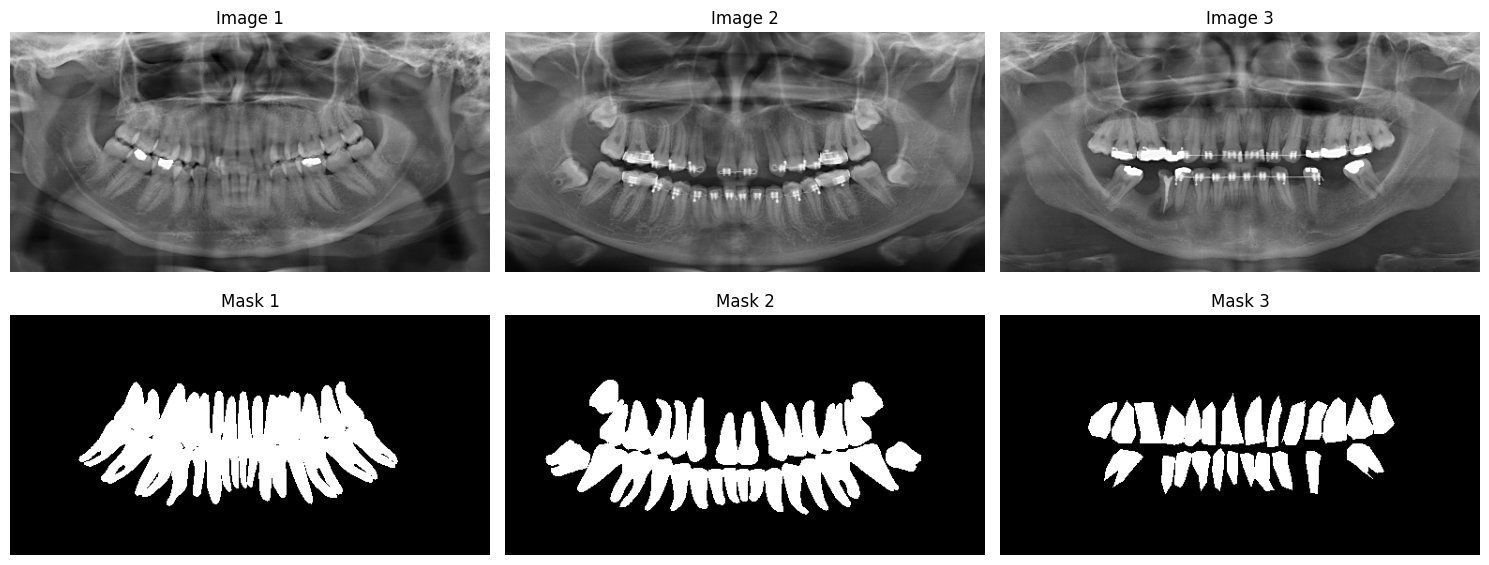

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(15,6))
offset = 200
for i in range(3):
    axes[0, i].imshow(trainImages[i+offset], cmap = 'gray')
    axes[0, i].set_title(f'Image {i+1}')
    axes[0, i].axis('off')

    axes[1, i].imshow(trainMasks[i+offset], cmap='gray')
    axes[1, i].set_title(f'Mask {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# Evaluation metrics.

In [21]:
def iou(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1,2,3])
    union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3]) - intersection
    iou = tf.reduce_mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def F1(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3])
    dice = tf.reduce_mean((2. * intersection + smooth) / (union + smooth), axis=0)
    return dice

def recall(y_true, y_pred):
	true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
	possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
	recall = true_positives / (possible_positives + K.epsilon())
	return recall

def specificity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    
    true_negatives = tf.reduce_sum(tf.cast((1 - y_true) * (1 - y_pred), tf.float32), axis=[1,2,3])
    possible_negatives = tf.reduce_sum(tf.cast(1 - y_true, tf.float32), axis=[1,2,3])
    specificity = tf.reduce_mean(true_negatives / (possible_negatives + K.epsilon()), axis=0)
    return specificity

def precision(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)), axis=[1,2,3])
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)), axis=[1,2,3])
    precision = tf.reduce_mean(true_positives / (predicted_positives + K.epsilon()), axis=0)
    return precision

def dice_coef(y_true, y_pred, smooth = 0.00001):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def log_coshx_dice_loss(y_true, y_pred):
    return K.log(tf.math.cosh(dice_loss(y_true, y_pred)))


# LCAT-Net model.

In [23]:
def channel_attention_module(x, ratio=8):
    batch, _, _, channel = x.shape

    ## Shared layers
    l1 = Dense(channel//ratio, activation="relu", use_bias=False)
    l2 = Dense(channel, use_bias=False)

    ## Global Average Pooling
    x1 = GlobalAveragePooling2D()(x)
    x1 = l1(x1)
    x1 = l2(x1)

    ## Global Max Pooling
    x2 = GlobalMaxPooling2D()(x)
    x2 = l1(x2)
    x2 = l2(x2)

    ## Add both the features and pass through sigmoid
    feats = x1 + x2
    feats = Activation("sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def spatial_attention_module(x):
    ## Average Pooling
    x1 = tf.reduce_mean(x, axis=-1)
    x1 = tf.expand_dims(x1, axis=-1)

    ## Max Pooling
    x2 = tf.reduce_max(x, axis=-1)
    x2 = tf.expand_dims(x2, axis=-1)

    ## Concatenat both the features
    feats = Concatenate()([x1, x2])
    ## Conv layer
    feats = Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def cbam(x):
    x = channel_attention_module(x)
    x = spatial_attention_module(x)
    return x
    
def ghost_module(inputs, drop_rate=0.3, block_size=7):
    conv1 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(inputs)
    batch1 = BatchNormalization()(conv1)
    act1 = Activation('relu')(batch1)
    conv2 = SeparableConv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(act1)
    return concatenate([act1, conv2], axis = 3)

def simple_conv2d(inputs, drop_rate=0.3, block_size=7):
    conv1 = Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal')(inputs)
    batch1 = BatchNormalization()(conv1)
    act1 = Activation('relu')(batch1)
    return act1

def scf_block(input_tensor, filters=512, rates=[1, 3, 5]):
    branches = []
    for rate in rates:
        branch = Conv2D(filters, (3, 3), padding='same', dilation_rate=rate, name="dilated_conv"+str(rate))(input_tensor)
        branch = tf.nn.relu(branch)
        branches.append(branch)
    output = Add()(branches)
    return output

def lcat_net(input_shape = (256, 512, 1)):

    inputs = Input(shape=input_shape, name="image")
    x1 = simple_conv2d(simple_conv2d(inputs)) # 256x512x128
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(x1)
    x2 = simple_conv2d(simple_conv2d(pool1)) # 128x256x128
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x3 = simple_conv2d(simple_conv2d(pool2)) # 64x128x128
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(x3)
    x4 = simple_conv2d(simple_conv2d(pool3)) # 32x64x128
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(x4)
    x5 = ghost_module(ghost_module(pool4)) # 16x32x128
    


    # Dense skip connections (Prepare sizes using MaxPlooings)
    down1to2 = MaxPooling2D(pool_size=(2, 2))(x1)
    down1to3 = MaxPooling2D(pool_size=(4, 4))(x1)
    down1to4 = MaxPooling2D(pool_size=(8, 8))(x1)
    down1to5 = MaxPooling2D(pool_size=(16, 16))(x1)

    down2to3 = MaxPooling2D(pool_size=(2, 2))(x2)
    down2to4 = MaxPooling2D(pool_size=(4, 4))(x2)
    down2to5 = MaxPooling2D(pool_size=(8, 8))(x2)


    down3to4 = MaxPooling2D(pool_size=(2, 2))(x3)
    down3to5 = MaxPooling2D(pool_size=(4, 4))(x3)
    
    down4to5 = MaxPooling2D(pool_size=(2, 2))(x4)
    down4to6 = MaxPooling2D(pool_size=(4, 4))(x4)
    
    # CBAMs
    cbam1 = cbam(x1) # CBAM_1
    cbam2 = cbam(Add()([x2,down1to2]))  # CBAM_2(DSM_1)
    cbam3 = cbam(Add()([x3,down1to3, down2to3]))  # CBAM_3(DSM_2)
    cbam4 = cbam(Add()([x4,down1to4, down2to4, down3to4])) # CBAM_4(DSM_3)
    cbam5 = cbam(Add()([x5,down1to5, down2to5, down3to5, down4to5])) # CBAM_4(DSM_4)

    # Upsamplings
    cbam2 = UpSampling2D(size = (2,2))(cbam2)
    cbam3 = UpSampling2D(size = (4,4))(cbam3)
    cbam4 = UpSampling2D(size = (8,8))(cbam4)
    cbam5 = UpSampling2D(size = (16,16))(cbam5)

    # MCF module
    rates = [1, 3, 5, 7] 
    scf = scf_block(x5, filters=128, rates=rates)
    mcf = Add()([cbam(scf), x5])
    mcf =  UpSampling2D(size = (16,16))(mcf)
    
    upScaled = Add()([cbam1, cbam2, cbam3, cbam4, cbam5, mcf])    

    all_conv = simple_conv2d(simple_conv2d(upScaled))
    final_conv = Conv2D(1, 1, activation = 'sigmoid')(all_conv)
    half_unet_model = tf.keras.Model(inputs, final_conv, name="LCAT-Net")
    return half_unet_model

# Training LCAT-Net.

In [25]:
model = lcat_net(input_shape)

In [26]:
from tensorflow import keras
model_path = '/kaggle/working/model.keras'
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics = ['accuracy', iou, F1, recall, specificity, precision, dice_coef])
callbacks = [
    keras.callbacks.ModelCheckpoint(model_path)
]
history_lcat_net = model.fit(
    trainImages, 
    trainMasks, 
    epochs=epochs, 
    batch_size=batch_size, 
    callbacks=callbacks
)

Epoch 1/100


I0000 00:00:1739544316.788729     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 [==============================] - 120s 395ms/step - loss: 0.1328 - accuracy: 0.9477 - iou: 0.7780 - F1: 0.8710 - recall: 0.8723 - specificity: 0.9676 - precision: 0.8807 - dice_coef: 0.8759
Epoch 2/100
250/250 [==============================] - 99s 395ms/step - loss: 0.0854 - accuracy: 0.9651 - iou: 0.8381 - F1: 0.9107 - recall: 0.9105 - specificity: 0.9794 - precision: 0.9170 - dice_coef: 0.9141
Epoch 3/100
250/250 [==============================] - 99s 395ms/step - loss: 0.0762 - accuracy: 0.9687 - iou: 0.8539 - F1: 0.9202 - recall: 0.9212 - specificity: 0.9810 - precision: 0.9242 - dice_coef: 0.9229
Epoch 4/100
250/250 [==============================] - 99s 395ms/step - loss: 0.0711 - accuracy: 0.9707 - iou: 0.8630 - F1: 0.9255 - recall: 0.9273 - specificity: 0.9820 - precision: 0.9282 - dice_coef: 0.9282
Epoch 5/100
250/250 [==============================] - 99s 395ms/step - loss: 0.0694 - accuracy: 0.9714 - iou: 0.8659 - F1: 0.9272 - recall: 0.9294 - specificity: 0.9825 -

# Calculating the evaluation metrics.

In [36]:
# Evaluate the model on the test data in batches
num_samples = len(validImages)
num_batches = (num_samples + batch_size - 1) // batch_size  # Calculate number of batches
all_metrics_values = []
table_data = []

for i in range(num_batches):
    start_index = i * batch_size
    end_index = min((i + 1) * batch_size, num_samples)
    images_batch = validImages[start_index:end_index]
    masks_batch = validMasks[start_index:end_index]
    
    # Evaluate the model on the batch
    loss, *metrics_values = model.evaluate(images_batch, masks_batch, verbose=0)
    all_metrics_values.append(metrics_values)

# Calculate mean and standard deviation of each metric across batches
mean_metrics = np.mean(all_metrics_values, axis=0)
std_metrics = np.std(all_metrics_values, axis=0)

# Prepare data for tabulation
headers = ["Metric Name", "Mean Value", "Standard Deviation"]

for i, metric_value in enumerate(mean_metrics):
    table_data.append([model.metrics_names[i+1], metric_value, std_metrics[i]])

# Print table
print(tabulate(table_data, headers=headers, tablefmt="grid"))

+---------------+--------------+----------------------+
| Metric Name   |   Mean Value |   Standard Deviation |
+===============+==============+======================+
| accuracy      |     0.977202 |           0.0136489  |
+---------------+--------------+----------------------+
| iou           |     0.90277  |           0.0581694  |
+---------------+--------------+----------------------+
| F1            |     0.947816 |           0.0328707  |
+---------------+--------------+----------------------+
| recall        |     0.987346 |           0.00537173 |
+---------------+--------------+----------------------+
| specificity   |     0.974843 |           0.0183141  |
+---------------+--------------+----------------------+
| precision     |     0.914003 |           0.0633727  |
+---------------+--------------+----------------------+
| dice_coef     |     0.947962 |           0.0328062  |
+---------------+--------------+----------------------+


# Save & Load {model, history}

In [28]:
import pickle
from keras.callbacks import History

def dict_to_history(history_dict):
    history = History()
    history.history = history_dict
    return history

def save_model_and_history(model, history, model_filename, history_filename):
    # Save the model
    model.save(model_filename)
    
    # Save the history
    with open(history_filename, 'wb') as file:
        pickle.dump(history.history, file)

def load_model_and_history(model_filename, history_filename):
    from keras.models import load_model
#     ['accuracy', iou, F1, recall, specificity, precision, dice_coef]
    # Load the model
    model = load_model(model_filename, custom_objects={"iou": iou ,"F1": F1, "recall": recall, "specificity": specificity, "precision":precision, "dice_coef": dice_coef})
    
    # Load the history
    with open(history_filename, 'rb') as file:
        history = pickle.load(file)
    
    return model, dict_to_history(history)

In [29]:
save_model_and_history(model, history_lcat_net, '/kaggle/working/lcat_net.h5', '/kaggle/working/lcat_net_history.pkl')


In [ ]:
model, history_lcat_net = load_model_and_history('/kaggle/working/lcat_net.h5', '/kaggle/working/lcat_net_history.pkl')

# Predict the segmentation masks of 10 samples.

1/1 [==============================] - 0s 24ms/step


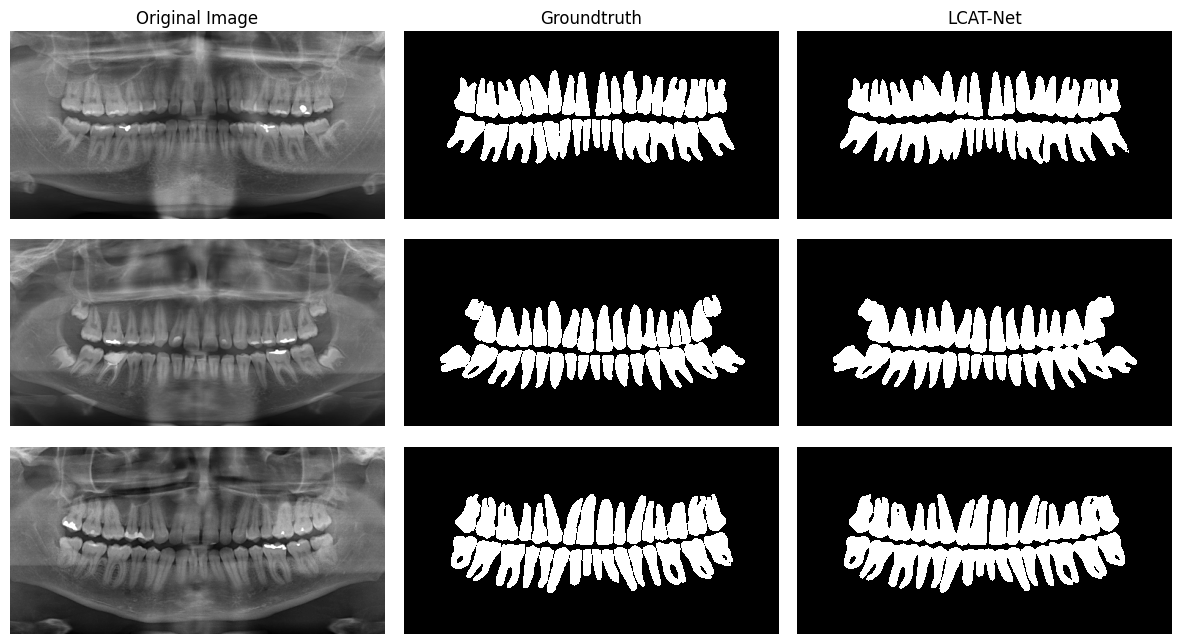

In [ ]:
   
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming model is defined and validImages, validMasks are your datasets.

# Predictions might be probabilities or raw scores, convert them to binary (0 or 1)
predictions = model.predict(validImages[:10])

# Define a custom color map: black, white, red, blue
white_or_black_cmap = mcolors.ListedColormap(['black', 'white'])

# Create a new figure and set its size
plt.figure(figsize=(15, 45))

for i in range(3):
    # Plotting the results
    plt.subplot(10, 3, i * 3 + 1)
    plt.imshow(validImages[i], cmap='gray')
    if i == 0:
        plt.title('Original Image')
    plt.axis('off')

    plt.subplot(10, 3, i * 3 + 2)
    plt.imshow(validMasks[i], cmap=white_or_black_cmap)
    if i == 0:
        plt.title('Groundtruth')
    plt.axis('off')

    plt.subplot(10, 3, i * 3 + 3)
    plt.imshow(predictions[i], cmap=white_or_black_cmap)
    if i == 0:
        plt.title('LCAT-Net')
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.05, hspace=-0.87)
plt.savefig(f"/kaggle/working/lcat_net_children_results.png", dpi=200, bbox_inches='tight', pad_inches=0)  # Save each figure with specified settings
plt.show()


# Visualize the errors: false positives (FP) in red and false negatives (FN) in green.

1/1 [==============================] - 0s 24ms/step


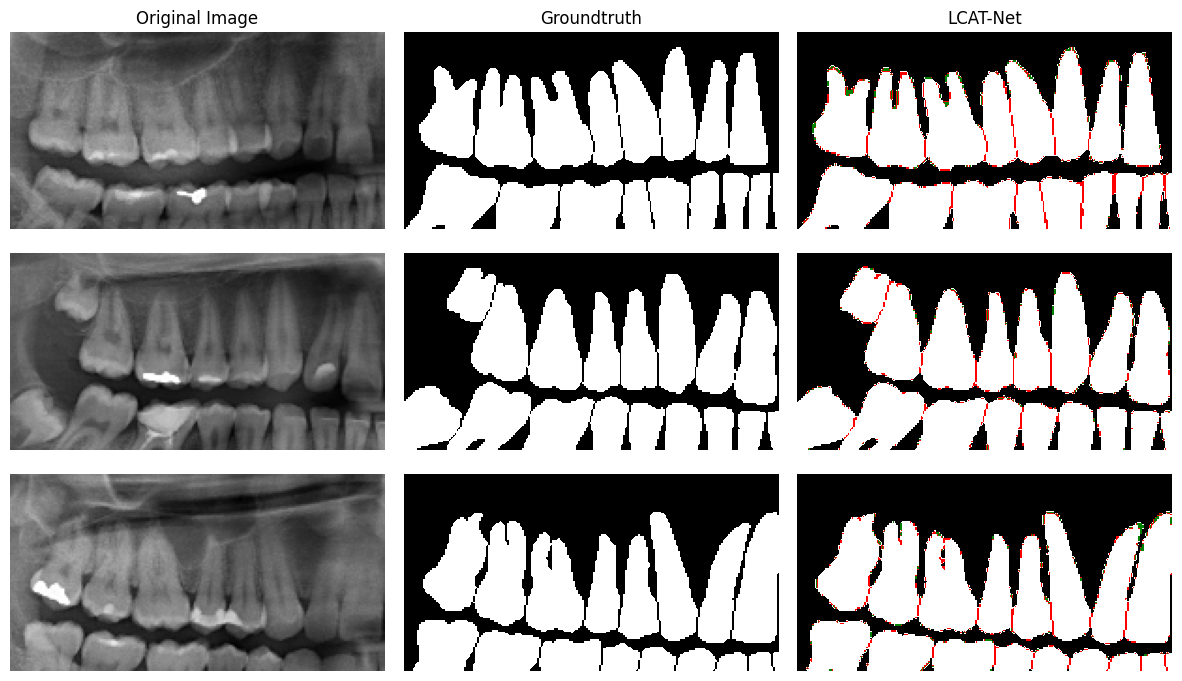

In [37]:
# Assuming model is defined and validImages, validMasks are your datasets.

# Predictions might be probabilities or raw scores, convert them to binary (0 or 1)
predictions = model.predict(validImages[:10])
binary_predictions = (predictions > .5).astype(int)  # Threshold at 0

# Define a custom color map: black, white, red, blue
# TP: white
# TN: black
# FP: red
# FN: green
cmap = mcolors.ListedColormap(['black', 'white', 'red', 'green'])

# Create a new figure and set its size
plt.figure(figsize=(15, 45))

for i in range(3):
    # Define cropping region
    b = 0;
    if i ==1:
        b+=30;
    crop_region = (45+b, 150+b, 60, 260)  # (top, bottom, left, right)

    # Crop images and masks
    cropped_image = validImages[i][crop_region[0]:crop_region[1], crop_region[2]:crop_region[3]]
    cropped_mask = validMasks[i][crop_region[0]:crop_region[1], crop_region[2]:crop_region[3]]
    cropped_prediction = binary_predictions[i][crop_region[0]:crop_region[1], crop_region[2]:crop_region[3]]

    # True Positive (prediction and ground truth are both 1)
    tp = (cropped_prediction == 1) & (cropped_mask == 1)
    # True Negative (prediction and ground truth are both 0)
    tn = (cropped_prediction == 0) & (cropped_mask == 0)
    # False Positive (prediction is 1, ground truth is 0)
    fp = (cropped_prediction == 1) & (cropped_mask == 0)
    # False Negative (prediction is 0, ground truth is 1)
    fn = (cropped_prediction == 0) & (cropped_mask == 1)

    # Combine into a single image with the custom colors
    display_mask = np.zeros_like(cropped_prediction)
    display_mask[tp] = 1  # White
    display_mask[tn] = 0  # Black
    display_mask[fp] = 2  # Red
    display_mask[fn] = 3  # Blue

    # Plotting the results
    plt.subplot(10, 3, i * 3 + 1)
    plt.imshow(cropped_image, cmap='gray')
    if i == 0:
        plt.title('Original Image')
    plt.axis('off')

    plt.subplot(10, 3, i * 3 + 2)
    plt.imshow(cropped_mask, cmap=mcolors.ListedColormap(['black', 'white']))  # Assuming mask is binary
    if i == 0:
        plt.title('Groundtruth')
    plt.axis('off')

    plt.subplot(10, 3, i * 3 + 3)
    plt.imshow(display_mask, cmap=cmap)
    if i == 0:
        plt.title('LCAT-Net')
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.05, hspace=-0.85)
plt.savefig(f"/kaggle/working/lcat_net_children_comparation.png", dpi=200, bbox_inches='tight', pad_inches=0)  # Save each figure with specified settings
plt.show()
